# *FINAL PROJECT - CS181*
Quan Phi

In [1]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import os.path
import json
import sqlalchemy as sa
import matplotlib.pyplot as plt

## A. Background information:
- In my proposal, I wanted to predict the result of each matchup in NBA playoff and predict the NBA champion this seasons(2021-2022). However, The playoff has just started so there are too many matchups. Therefore, I want to focus on the most thorny one of the NBA play-off in the first round: Boston Celtics vs Brooklyn Nets. 
## B. Topic Question:
- Who is the winner of the hardest matchup in NBA first round play-off: Boston Celtics or Brooklyn Nets.

*Contents*
1. Data description.
1. Scraping data from webpage and turning it into a table in sql.
2. Converting 2 csv files into 2 tables in sql.
3. Write a query to extract data from sql dataframe.
4. Analyzing data.
5. Conclusion.

In [2]:
# Create connection for sql database
cstring = "sqlite:///basketball.db"
engine = sa.create_engine(cstring, echo = True)
connection = engine.connect()

### 1. Data description:
    Web-scraping:
https://projects.fivethirtyeight.com/2022-nba-predictions/ 
This dataset was about the strength ranking of NBA teams in the play off this season.

    csv file from kaggle:
https://www.kaggle.com/datasets/nathanlauga/nba-games
This dataset include information of all NBA games this season(point, team,...).

### 2. Scraping data from webpage and turning it into a table in sql (Strength table):
- The website I scrape has strength index of each NBA team which is very powerful and helpful to solve my topic question.
- First, I planned to scrape the NBA.com but then I found those data on kaggle so I decided to scrape "https://projects.fivethirtyeight.com/2022-nba-predictions/".
- I used the web url and parse html. Then, I use panda to create dataframe.

In [3]:

def scraping():
    """
    Scrape the web to extract data from the table about the strength index of the nba teams in the 2022 playoff.
    """
    ### Scraping data using beautifulsoup

    url = "https://projects.fivethirtyeight.com/2022-nba-predictions/"
    result = requests.get(url)
    c = result.content
    soup = BeautifulSoup(c,"html.parser")
    games = soup.find("table", id = "standings-table")
    strength_raw = pd.read_html(str(games))[0]

    ### Cleaning data before converting it into a sql table
    
    strength_raw.columns = strength_raw.columns.droplevel()
    strength_raw["Chance of Winning FinalsWin Finals"]
    strength = strength_raw[["Current rating","Conference", "Full-strength rating", "Team"]]
    strength.rename(columns={"Current rating":"Currentrating","Full-strength rating":"Fullstrengthrating"}, inplace=True)
    for i in range(len(strength)):
        string1 = strength.loc[i,"Team"]
        strength.loc[i,"Team"] = re.sub(r'[^a-zA-Z67]+', '', string1)
    strength = strength[["Team","Conference","Currentrating","Fullstrengthrating"]]
    strength = strength.loc[0:15]
    return strength
scraping()

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Team,Conference,Currentrating,Fullstrengthrating
0,Celtics,East,1775,1775
1,Suns,West,1658,1706
2,Warriors,West,1678,1670
3,Bucks,East,1688,1719
4,Heat,East,1618,1687
5,76ers,East,1671,1686
6,Grizzlies,West,1663,1656
7,Mavericks,West,1647,1670
8,Jazz,West,1649,1648
9,Pelicans,West,1546,1604


- "Team": team name of NBA team in the playoff this season
- "Conference": Conference of each team.
- "Currentrating": Strength index of each team now.
- "Fullstrengthrating": Predicted maximum strength index of each team.
- Normally, the "Currentrating" is less than "Fullstrengthrating" because there might be some players having injuries. If the "Currentrating" is higher than "Fullstrengthrating", the reason might be some of the players having better performance or other things like changing strategy that leads to better performance of the team. 

In [4]:
# Create table for Strength of teams
statement1 = """
CREATE TABLE IF NOT EXISTS Strength (
    Team VARCHAR(64) PRIMARY KEY,
    Conference CHAR(4),
    Currentrating INTEGER NOT NULL,
    Fullstrengthrating INTEGER NOT NULL
)
"""
# Execute the statement
connection.execute(statement1)
# Query to check the table after inserting data
query1 = """
    SELECT *
    FROM Strength
    """
df_Strength = pd.read_sql_query(query1, con=connection)

2022-04-24 21:57:40,593 INFO sqlalchemy.engine.Engine 
CREATE TABLE IF NOT EXISTS Strength (
    Team VARCHAR(64) PRIMARY KEY,
    Conference CHAR(4),
    Currentrating INTEGER NOT NULL,
    Fullstrengthrating INTEGER NOT NULL
)

2022-04-24 21:57:40,595 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-24 21:57:40,595 INFO sqlalchemy.engine.Engine COMMIT
2022-04-24 21:57:40,598 INFO sqlalchemy.engine.Engine 
    SELECT *
    FROM Strength
    
2022-04-24 21:57:40,598 INFO sqlalchemy.engine.Engine [raw sql] ()


In [5]:
def create_strength_sql():
    """
    adding the strength dataframe to the sql table
    """
    strength = scraping()
    stmt1 = """
        INSERT INTO Strength
        VALUES (:Team, :Conference, :Currentrating, :Fullstrengthrating)
    """
    if df_Strength.shape == (0,4):

        prepare_insert = sa.sql.text(stmt1)

        # Iterate through the rows in the DataFrame
        for rowlabel, rowseries in strength.iterrows():
            # Bind variables (match :x in statement)
            bound_insert = prepare_insert.bindparams(**rowseries) # some fancy Python

            # Execute
            rp = connection.execute(bound_insert)
    return

        The "Strength" sql table has 4 fields (the same format with the panda dataset from the strength() function) with "Team" as primary key and "Team" as foreign key as well

In [6]:
#Test if the data is fully inserted to sql table
create_strength_sql()
df_Strength = pd.read_sql_query(query1, con=connection)
assert df_Strength.shape == (16,4)

2022-04-24 21:57:40,997 INFO sqlalchemy.engine.Engine 
    SELECT *
    FROM Strength
    
2022-04-24 21:57:40,998 INFO sqlalchemy.engine.Engine [raw sql] ()


C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### 3. Converting 2 csv files into 2 tables in sql.
#### a, All games of 2021-2022 season (Game table).

In [7]:
def games():
    """
    convert csv file of all season 2021-22 games to panda dataframe
    """
    f = open('games.csv','r')
    read = pd.read_csv(f)
    games = read.loc[read.SEASON==2021]
    games = games[["GAME_ID","HOME_TEAM_ID", "VISITOR_TEAM_ID","PTS_home","PTS_away", "HOME_TEAM_WINS"]]
    return games
games()

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,PTS_home,PTS_away,HOME_TEAM_WINS
0,22101005,1610612748,1610612750,104.0,113.0,0
1,22101006,1610612741,1610612739,101.0,91.0,1
2,22101007,1610612759,1610612754,108.0,119.0,0
3,22101008,1610612744,1610612749,122.0,109.0,1
4,22101009,1610612743,1610612761,115.0,127.0,0
...,...,...,...,...,...,...
1071,12100007,1610612759,1610612762,111.0,85.0,1
1072,12100008,1610612757,1610612744,107.0,121.0,0
1073,12100009,1610612758,1610612756,117.0,106.0,1
1074,12100010,1610612746,1610612743,103.0,102.0,1


* "GAME_ID": game id.
* "HOME_TEAM_ID": id of home team.
* "VISITOR_TEAM_ID": id of visitor team.
* "PTS_home": Point of home team.
* "PTS_away": Point of visitor team.
* "HOME_TEAM_WINS": Result of game(0 if home_team lose, 1 if home_team win)

In [8]:
# Create sql table for all season games
statement2 = """
CREATE TABLE IF NOT EXISTS Game (
    GAME_ID INT PRIMARY KEY,
    HOME_TEAM_ID INT NOT NULL,
    VISITOR_TEAM_ID INT NOT NULL,
    PTS_home INT NOT NULL,
    PTS_away INT NOT NULL,
    HOME_TEAM_WINS INT NOT NULL
)
"""
# Execute the statement
connection.execute(statement2)
# Query to check the table after inserting data
query2 = """
SELECT *
FROM Game
"""
df_Game = pd.read_sql_query(query2, con=connection)

2022-04-24 21:57:41,220 INFO sqlalchemy.engine.Engine 
CREATE TABLE IF NOT EXISTS Game (
    GAME_ID INT PRIMARY KEY,
    HOME_TEAM_ID INT NOT NULL,
    VISITOR_TEAM_ID INT NOT NULL,
    PTS_home INT NOT NULL,
    PTS_away INT NOT NULL,
    HOME_TEAM_WINS INT NOT NULL
)

2022-04-24 21:57:41,221 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-24 21:57:41,222 INFO sqlalchemy.engine.Engine COMMIT
2022-04-24 21:57:41,223 INFO sqlalchemy.engine.Engine 
SELECT *
FROM Game

2022-04-24 21:57:41,224 INFO sqlalchemy.engine.Engine [raw sql] ()


In [9]:
def create_game_sql():
    """
    adding the game dataframe to the sql table
    """
    game = games()
    stmt2 = """
        INSERT INTO Game
        VALUES (:GAME_ID, :HOME_TEAM_ID, :VISITOR_TEAM_ID, :PTS_home, :PTS_away, :HOME_TEAM_WINS)
    """

    if df_Game.shape == (0,6):

        prepare_insert = sa.sql.text(stmt2)

        # Iterate through the rows in the DataFrame
        for rowlabel, rowseries in game.iterrows():
            # Bind variables (match :x in statement)
            bound_insert = prepare_insert.bindparams(**rowseries) # some fancy Python

            # Execute
            rp = connection.execute(bound_insert)
    return

        The "game" sql table has 6 fields (the same format with the panda dataset from the games() function) with "GAME_ID" as Primary key and HOME_TEAM_ID and VISITOR_TEAM_ID as Foreign key

In [10]:
# Test if the data is fully inserted to sql table
create_game_sql()
df_Game = pd.read_sql_query(query2, con=connection)
assert df_Game.shape == (1076,6)

2022-04-24 21:57:41,454 INFO sqlalchemy.engine.Engine 
SELECT *
FROM Game

2022-04-24 21:57:41,454 INFO sqlalchemy.engine.Engine [raw sql] ()


#### b, Team_id and team name (Team table):  

In [11]:
def teams():
    """
    convert csv file of all nba teams id and nicknames to panda dataframe
    """
    f = open('teams.csv','r')
    read = pd.read_csv(f)
    teams = read[["TEAM_ID","NICKNAME"]]
    return teams
teams()

,TEAM_ID,NICKNAME
0,1610612737,Hawks
1,1610612738,Celtics
2,1610612740,Pelicans
3,1610612741,Bulls
4,1610612742,Mavericks
5,1610612743,Nuggets
6,1610612745,Rockets
7,1610612746,Clippers
8,1610612747,Lakers
9,1610612748,Heat


- "TEAM_ID": id of the team	
- "NICKNAME": name of the team
- This is the table that helps connect the "strength" table with and "game" table. 

In [12]:
# Create sql table for team id and nicknames 
statement3 = """
CREATE TABLE IF NOT EXISTS Team (
    TEAM_ID INT PRIMARY KEY,
    NICKNAME VARCHAR(20) NOT NULL
)
"""
# Execute the statement
connection.execute(statement3)
# Query to check the table after inserting data
query3 = """
SELECT *
FROM Team
"""
df_Team = pd.read_sql_query(query3, con=connection)

2022-04-24 21:57:41,562 INFO sqlalchemy.engine.Engine 
CREATE TABLE IF NOT EXISTS Team (
    TEAM_ID INT PRIMARY KEY,
    NICKNAME VARCHAR(20) NOT NULL
)

2022-04-24 21:57:41,563 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-24 21:57:41,564 INFO sqlalchemy.engine.Engine COMMIT
2022-04-24 21:57:41,565 INFO sqlalchemy.engine.Engine 
SELECT *
FROM Team

2022-04-24 21:57:41,565 INFO sqlalchemy.engine.Engine [raw sql] ()


In [13]:
def create_team_sql():
    """
    adding the 'team' dataframe to the sql table
    """
    team = teams()
    stmt3 = """
        INSERT INTO Team
        VALUES (:TEAM_ID, :NICKNAME)
    """

    if df_Team.shape == (0,2):

        prepare_insert = sa.sql.text(stmt3)

        # Iterate through the rows in the DataFrame
        for rowlabel, rowseries in team.iterrows():
            # Bind variables (match :x in statement)
            bound_insert = prepare_insert.bindparams(**rowseries) # some fancy Python

            # Execute
            rp = connection.execute(bound_insert)
    return

    The "game" sql table has 2 fields which looks like the panda dataset. The Primary key is "TEAM_ID" and foreign keys are both "TEAM_ID" and "NICKNAME". The main purpose of this table is to connect the first 2 one ("Strength" and "Team")

In [14]:
# Test if the data is fully inserted to sql table
create_team_sql()
df_Team = pd.read_sql_query(query3, con=connection)
assert df_Team.shape == (30,2)

2022-04-24 21:57:41,656 INFO sqlalchemy.engine.Engine 
SELECT *
FROM Team

2022-04-24 21:57:41,657 INFO sqlalchemy.engine.Engine [raw sql] ()


### 4. Write a query to extract data from sql dataframe.
- My main goal here is to join the "Strength" and "Game" together using "Team"
- "Strength" has foreign key "TEAM" which is "NICKNAME" in "Team". "Game" has foreign key "VISITOR_TEAM_ID" and "HOME_TEAM_ID" matching "TEAM_ID" of "Team". 

In [15]:
### Inner-join 3 table Team, Strength and Game to get the team matchup result and strength number.

query4 = """
SELECT big.GAME_ID, big.TEAM_ID, big.VISITOR_TEAM_ID, big.Team, big.Conference AS Team_conf, Team.NICKNAME AS Opponent, big.Currentrating, big.PTS_home, big.PTS_away, big.HOME_TEAM_WINS
FROM 
(SELECT GAME_ID, TEAM_ID, VISITOR_TEAM_ID, Team, Conference, Currentrating, PTS_home, PTS_away, HOME_TEAM_WINS
FROM
Game INNER JOIN Team ON Team.TEAM_ID = Game.HOME_TEAM_ID INNER JOIN Strength ON Team.NICKNAME = Strength.Team) AS big INNER JOIN Team 
ON big.VISITOR_TEAM_ID = Team.Team_ID
"""
df = pd.read_sql_query(query4, con=connection)
df

2022-04-24 21:57:41,702 INFO sqlalchemy.engine.Engine 
SELECT big.GAME_ID, big.TEAM_ID, big.VISITOR_TEAM_ID, big.Team, big.Conference AS Team_conf, Team.NICKNAME AS Opponent, big.Currentrating, big.PTS_home, big.PTS_away, big.HOME_TEAM_WINS
FROM 
(SELECT GAME_ID, TEAM_ID, VISITOR_TEAM_ID, Team, Conference, Currentrating, PTS_home, PTS_away, HOME_TEAM_WINS
FROM
Game INNER JOIN Team ON Team.TEAM_ID = Game.HOME_TEAM_ID INNER JOIN Strength ON Team.NICKNAME = Strength.Team) AS big INNER JOIN Team 
ON big.VISITOR_TEAM_ID = Team.Team_ID

2022-04-24 21:57:41,703 INFO sqlalchemy.engine.Engine [raw sql] ()


,GAME_ID,TEAM_ID,VISITOR_TEAM_ID,Team,Team_conf,Opponent,Currentrating,PTS_home,PTS_away,HOME_TEAM_WINS
0,22101005,1610612748,1610612750,Heat,East,Timberwolves,1677,104,113,0
1,22101006,1610612741,1610612739,Bulls,East,Cavaliers,1494,101,91,1
2,22101008,1610612744,1610612749,Warriors,West,Bucks,1681,122,109,1
3,22101009,1610612743,1610612761,Nuggets,West,Raptors,1568,115,127,0
4,22101010,1610612762,1610612758,Jazz,West,Kings,1649,134,125,1
...,...,...,...,...,...,...,...,...,...,...
571,12100014,1610612763,1610612749,Grizzlies,West,Bucks,1655,87,77,1
572,12100002,1610612761,1610612755,Raptors,East,76ers,1576,123,107,1
573,12100003,1610612738,1610612753,Celtics,East,Magic,1753,98,97,1
574,12100004,1610612748,1610612737,Heat,East,Hawks,1677,125,99,1


## 5. Analyzing data.


        To predict the result of matchup I will use 4 main keys:
                a, Compare the current strength of 2 teams.
                b, Compare their history in this season(meeting each others 4 times).
                c, Calculate the average fifference score each match.  
        
#### a, Compare the current strength of 2 teams.

In [16]:
query5 = """
Select *
FROM Strength
"""
part_a = pd.read_sql_query(query5, con=connection)
part_a.loc[(part_a.Team == "Celtics")|(part_a.Team == "Nets"),("Team", "Currentrating")]

2022-04-24 21:57:41,774 INFO sqlalchemy.engine.Engine 
Select *
FROM Strength

2022-04-24 21:57:41,775 INFO sqlalchemy.engine.Engine [raw sql] ()


,Team,Currentrating
0,Celtics,1753
9,Nets,1607


        Celtics has 1753 while Nets have 1607 so for part a, Celtics won. The score is 1-0 for Celtics
#### b, Compare their history in this season(meeting each others 4 times).

In [17]:
b = df.loc[((df.Team == "Celtics") & (df.Opponent == "Nets")) | ((df.Opponent == "Celtics") & (df.Team == "Nets"))]
b.replace(1, "Home team won", inplace=True)
b.replace(0, "Opponent team won", inplace=True)
b

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,GAME_ID,TEAM_ID,VISITOR_TEAM_ID,Team,Team_conf,Opponent,Currentrating,PTS_home,PTS_away,HOME_TEAM_WINS
26,22100960,1610612738,1610612751,Celtics,East,Nets,1753,126,120,Home team won
66,22100890,1610612751,1610612738,Nets,East,Celtics,1607,106,129,Opponent team won
112,22100817,1610612751,1610612738,Nets,East,Celtics,1607,91,126,Opponent team won
395,22100270,1610612738,1610612751,Celtics,East,Nets,1753,104,123,Opponent team won


        According to the table, Celtics won three games out of four. Therefore, this time, the score is 2-0 for Celtics
#### c, Calculate the average difference score each match:
- For this part, I will calculate the sum of point that each team have after 4 games, minus each other to get the difference and divide it by 4. 

In [18]:
b["Score_difference"] = b.PTS_home - b.PTS_away
c = b[["Team", "Opponent", "PTS_home", "PTS_away"]]
c

<ipython-input-18-f057e0a8dcb3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b["Score_difference"] = b.PTS_home - b.PTS_away


,Team,Opponent,PTS_home,PTS_away
26,Celtics,Nets,126,120
66,Nets,Celtics,106,129
112,Nets,Celtics,91,126
395,Celtics,Nets,104,123


11.25


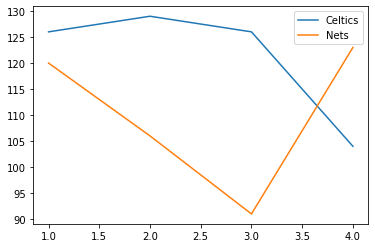

In [19]:
Celtics = [126,129,126,104]
Nets = [120,106,91,123]
x = [1,2,3,4]
avg_diff = (sum(Celtics) - sum(Nets))/4 
print(avg_diff)

plt.plot(x, Celtics, label = "Celtics")
plt.plot(x, Nets, label = "Nets")
plt.legend()
plt.show()

        In average, the Celtics exceed Nets 11.25, so Celtics won again, 3-0.
### 6. Conclusion:
        After 3 times of comparing, Celtics totally defeated Nets based on their history meeting and power index. Therefore, I predict that in this serie, Celtics will win.

In [20]:
# Close the connection
connection.close()